# Pong with Advantage Actor Critic

## Step 1: Import the libraries

In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

/home/schneialexan@edu.local/miniconda3/envs/rl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../../')
from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
env = gym.make('ALE/Pong-v5', render_mode="rgb_array")
env.seed(0)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(2968811710, 3677149159)

In [4]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


/home/schneialexan@edu.local/miniconda3/envs/rl/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:290: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


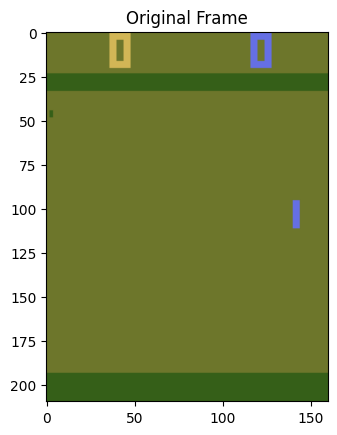

In [5]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.render())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [6]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        score += reward
        if terminated:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  -21.0


## Step 4:Preprocessing Frame

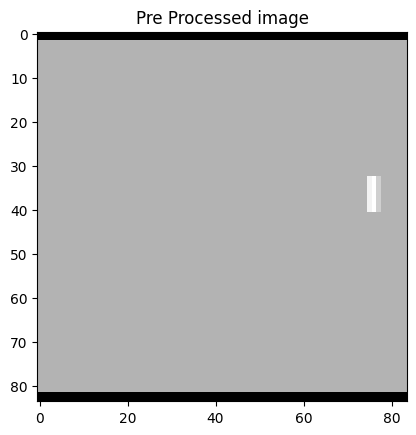

In [7]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.render(), (30, -4, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [8]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (30, -4, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [9]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.00001          # Actor learning rate
BETA = 0.00005          # Critic learning rate
UPDATE_EVERY = 10      # how often to update the network 

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)

## Step 7: Watching untrained agent play

In [10]:

# watch an untrained agent
state = stack_frames(None, env.render(), True) 
for j in range(200):
    env.render()
    action, _, _ = agent.act(state)
    observation, reward, terminated, truncated, info = env.step(action)
    state = stack_frames(state, observation, False)
    if terminated:
        break 
        
env.close()

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [11]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

In [12]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        env.reset()
        state = stack_frames(None, env.render(), True)
        score = 0
        while True:
            action, log_prob, entropy = agent.act(state)
            observation, reward, terminated, truncated, info= env.step(action)
            score += reward
            next_state = stack_frames(state, observation, False)
            agent.step(state, log_prob, entropy, reward, terminated, next_state)
            state = next_state
            if terminated:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_net.state_dict(), f'models/actor_model_a2c_{i_episode}.pth')
            torch.save(agent.critic_net.state_dict(), f'models/critic_model_a2c_{i_episode}.pth')
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    torch.save(agent.actor_net.state_dict(), 'models/actor_model_a2c.pth')
    torch.save(agent.critic_net.state_dict(), 'models/critic_model_a2c.pth')
    return scores

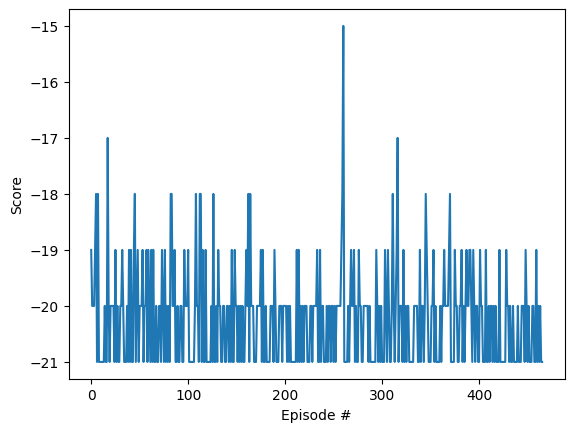

Episode 4666	Average Score: -20.45

In [13]:
start_epoch = 4200
agent.actor_net.load_state_dict(torch.load(f'models/actor_model_a2c_{start_epoch}.pth'))
agent.critic_net.load_state_dict(torch.load(f'models/critic_model_a2c_{start_epoch}.pth'))
scores = train(start_epoch + 1000)

## Step 10: Watch a Smart Agent!

In [ ]:
import imageio
env.reset()
score = 0
state = stack_frames(None, env.render(), True)
to_animate = []	
while True:
    to_animate.append(env.render())
    action, log_prob, entropy = agent.act(state)
    observation, reward, terminated, truncated, info= env.step(action)
    score += reward
    next_state = stack_frames(state, observation, False)
    state = next_state
    if terminated:
        break
env.close()
imageio.mimsave('gifs/a2c.gif', to_animate)